## 1) Нарисуйте (в каком-то виде) графики траекторий из data.csv.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'data.csv'
data = pd.read_csv(file_path)

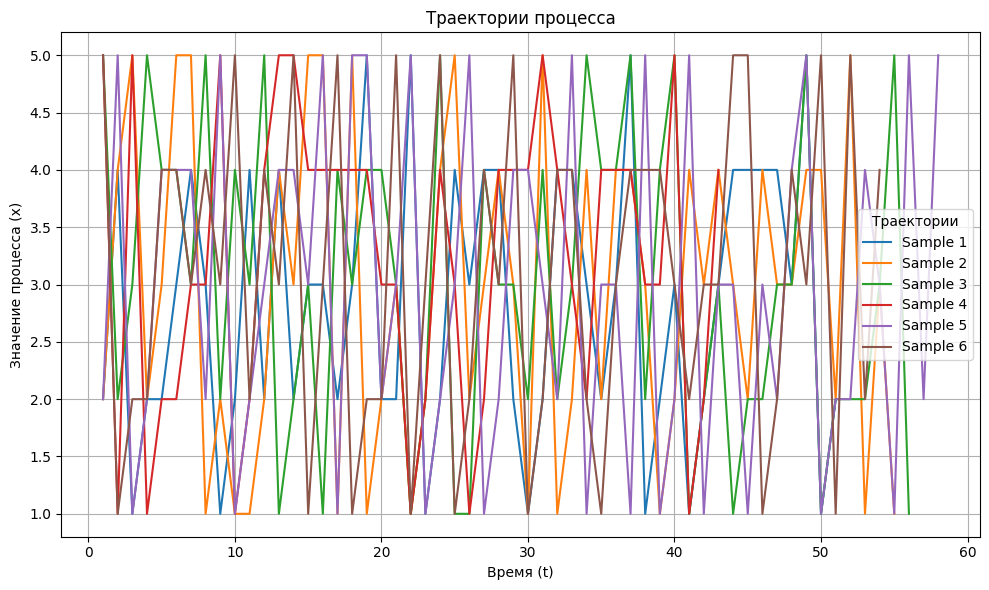

In [2]:
plt.figure(figsize=(10, 6))

for sample in data['sample'].unique():
    trajectory = data[data['sample'] == sample]
    plt.plot(trajectory['t'], trajectory['x'], label=f'Sample {sample}')

# Настройки графика
plt.title('Траектории процесса')
plt.xlabel('Время (t)')
plt.ylabel('Значение процесса (x)')
plt.legend(title='Траектории')
plt.grid(True)
plt.tight_layout()

# Показ графика
plt.show()

## 2) Получите в явном виде оценки максимального правдоподобия $\pi$ и P для нескольким независимым выборочным траекториям.

Вот такая формула для $\hat{\pi}_k$:
$$
\hat{\pi}_k = \frac{\#(x_{i1} = k)}{\sum_{k=1}^{p} \#(x_{i1} = k)}
$$
И вот такая для P:
$$
P_{lm} = \frac{\#(x_{it} = m, x_{it-1} = l)}{\sum_{m=1}^{p} \#(x_{it} = m, x_{it-1} = l)}
$$
Запрограмируем 

In [3]:
def estimate_initial_distribution(data,n):
    initial_dist = np.zeros(n)
    for i in data[data['t'] == 1]['x']:
        initial_dist[i-1] += 1
    pi = initial_dist / np.sum(initial_dist) 
    return pi


def estimate_transition_matrix(data,n):
    transition_matrix = np.zeros((n,n))
    for sample in data['sample'].unique():
        trajectory = data[data['sample'] == sample]
        for i in range(len(trajectory) - 1):
            current_state = trajectory.iloc[i]['x']
            next_state = trajectory.iloc[i + 1]['x']
            transition_matrix[current_state-1,next_state-1] += 1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = np.divide(transition_matrix, row_sums, where=row_sums != 0)
    return normalized_matrix




## 3) Оцените $\pi$ и P по методу максимального правдоподобия исходя из данных в data.csv.

In [4]:
pi = estimate_initial_distribution(data,5)
pi

array([0. , 0.5, 0. , 0. , 0.5])

In [5]:
P = estimate_transition_matrix(data,5)
P

array([[0.03846154, 0.65384615, 0.13461538, 0.03846154, 0.13461538],
       [0.04225352, 0.12676056, 0.28169014, 0.42253521, 0.12676056],
       [0.21538462, 0.12307692, 0.15384615, 0.15384615, 0.35384615],
       [0.01428571, 0.11428571, 0.4       , 0.37142857, 0.1       ],
       [0.64150943, 0.18867925, 0.        , 0.0754717 , 0.09433962]])

## 4) Пусть $( X_1,..., X_n )$ — значения из первой выборочной траектории (где \( n \) — последний момент времени, для которого присутствует наблюдение в выборочной траектории). Исходя из полученных оценок для начального распределения и матрицы переходных вероятностей, вычислите условные вероятности: $P(\xi(n+1) = x \mid X_1,..., X_n)$ и $P(\xi(n+2) = x \mid X_1,..., X_n)$ для всех x $\in$ $\text{dom}\xi$.



In [6]:
def get_future_step(last_record,Pf,step):
    result = Pf[last_record["x"]-1]
    for _ in range(step-1):
        result = result @ Pf
    return result

In [7]:
last_record = data[data['sample'] == 1].iloc[-1]
t1 = get_future_step(last_record,P,1)
print(t1)
t2 = get_future_step(last_record,P,2)
print(t2)


[0.04225352 0.12676056 0.28169014 0.42253521 0.12676056]
[0.15500725 0.15057192 0.2537462  0.26503137 0.17564325]


## ЗАДАНИЕ 2

In [8]:

import random
def generate_markov_trajectory(pi,P,sample,max_t):
    t1 = np.random.choice(len(pi), p=pi)
    trajectory = [[sample, 1, t1 + 1]]
    
    for t in range(1, max_t):
        current_state = trajectory[-1][2] - 1 
        next_state = np.random.choice(len(P), p=P[current_state])
        trajectory.append([sample, t+1, next_state + 1]) 
    
    return trajectory

In [9]:
a = generate_markov_trajectory(pi,P,1,5)
a

[[1, 1, 5], [1, 2, 2], [1, 3, 3], [1, 4, 1], [1, 5, 4]]

In [10]:
from tqdm import tqdm
pi_results = []
P_results = []
last_records = []

pt1_result = []
pt2_result = []

max_t_per_sample = data.groupby('sample')['t'].max()
for k in tqdm(range(1000), desc="Итерации"):
    trajectories = []
    for sample in range(1,7):
        max_t = max_t_per_sample.get(sample, random.randint(45, 60))
        traj = generate_markov_trajectory(pi,P,sample,max_t)
        trajectories.extend(traj)
        
    new_data = pd.DataFrame(trajectories, columns=["sample", "t", "x"])
    last_record = new_data[new_data['sample'] == 1].iloc[-1]
    
    pi_new = estimate_initial_distribution(new_data,5)
    P_new = estimate_transition_matrix(new_data,5)
    
    pi_results.append(pi_new)
    P_results.append(P_new)
    last_records.append(last_record)
    
    


Итерации: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.96it/s]


# Дисперсии для $\pi$ и $P$

In [11]:
# Оценка дисперсии для pi
pi_var = np.var(pi_results, axis=0)  # Дисперсия для каждого элемента pi

# # Оценка квантильных интервалов для pi
# pi_lower = np.quantile(pi_results, 0.05, axis=0)
# pi_upper = np.quantile(pi_results, 0.95, axis=0)

# Оценка дисперсии для P
P_var = np.var(P_results, axis=0)  # Дисперсия для каждого элемента P

# Оценка квантильных интервалов для P
# P_lower = np.quantile(P_results, 0.05, axis=0)
# P_upper = np.quantile(P_results, 0.95, axis=0)

In [12]:
df_pi = pd.DataFrame({
    'Дисперсия': pi_var})
    # '05_Квантиль': pi_lower,
    # '95_Квантиль': pi_upper})
df_P_var = pd.DataFrame(P_var, columns=[i + 1 for i in range(P_var.shape[1])], 
                        index=[i + 1 for i in range(P_var.shape[0])])
print("\nДисперсия для pi")
display(df_pi)
print("\nДисперсия для P:")
display(df_P_var)



Дисперсия для pi


,Дисперсия
0,0.000000
1,0.040719
2,0.000000
3,0.000000
4,0.040719



Дисперсия для P:


,1,2,3,4,5
1,0.000672,0.004400,0.002244,0.000685,0.002236
2,0.000605,0.001469,0.002765,0.003483,0.001530
3,0.002617,0.001725,0.002147,0.002163,0.003558
4,0.000204,0.001420,0.003534,0.003417,0.001309
5,0.004346,0.002849,0.000000,0.001268,0.001479


In [13]:
# df_P_lower = pd.DataFrame(P_lower, columns=[i + 1 for i in range(P_lower.shape[1])], 
#                           index=[i + 1 for i in range(P_lower.shape[0])])

# df_P_upper = pd.DataFrame(P_upper, columns=[i + 1 for i in range(P_upper.shape[1])], 
#                           index=[i + 1 for i in range(P_upper.shape[0])])


# print("0.9-квантильные интервалы для P:")
# print("Нижняя граница:\n")
# display(df_P_lower)
# print("Верхняя граница:\n")
# display(df_P_upper)

## 0.9 Квантиль Для $P(\xi(n+1))$

In [14]:
# pt1_var = np.var(pt1_result, axis=0)
pt1_result = np.array([get_future_step(record, P_new, 1) for record, P_new in zip(last_records, P_results)])
pt1_lower = np.quantile(pt1_result, 0.05, axis=0)
pt1_upper = np.quantile(pt1_result, 0.95, axis=0)

# print(pt1_var)
print(pt1_lower)
print(pt1_upper)

[0.         0.06737828 0.         0.01885045 0.0516803 ]
[0.67216095 0.69356485 0.451635   0.47063025 0.38718638]


## 0.9 Квантиль Для $P(\xi(n+2))$

In [15]:
# pt2_var = np.var(pt2_result, axis=0)
pt2_result = np.array([get_future_step(record, P_new, 2) for record, P_new in zip(last_records, P_results)])
pt2_lower = np.quantile(pt2_result, 0.05, axis=0)
pt2_upper = np.quantile(pt2_result, 0.95, axis=0)

# print(pt2_var)
print(pt2_lower)
print(pt2_upper)

[0.07744272 0.10849985 0.12792461 0.11863035 0.10456451]
[0.30234321 0.4826586  0.28630373 0.35270931 0.2329322 ]


## Гистограммы для p{0,0} p{2,2} p{4,4} и pi{1}, pi{4}, pi{0}

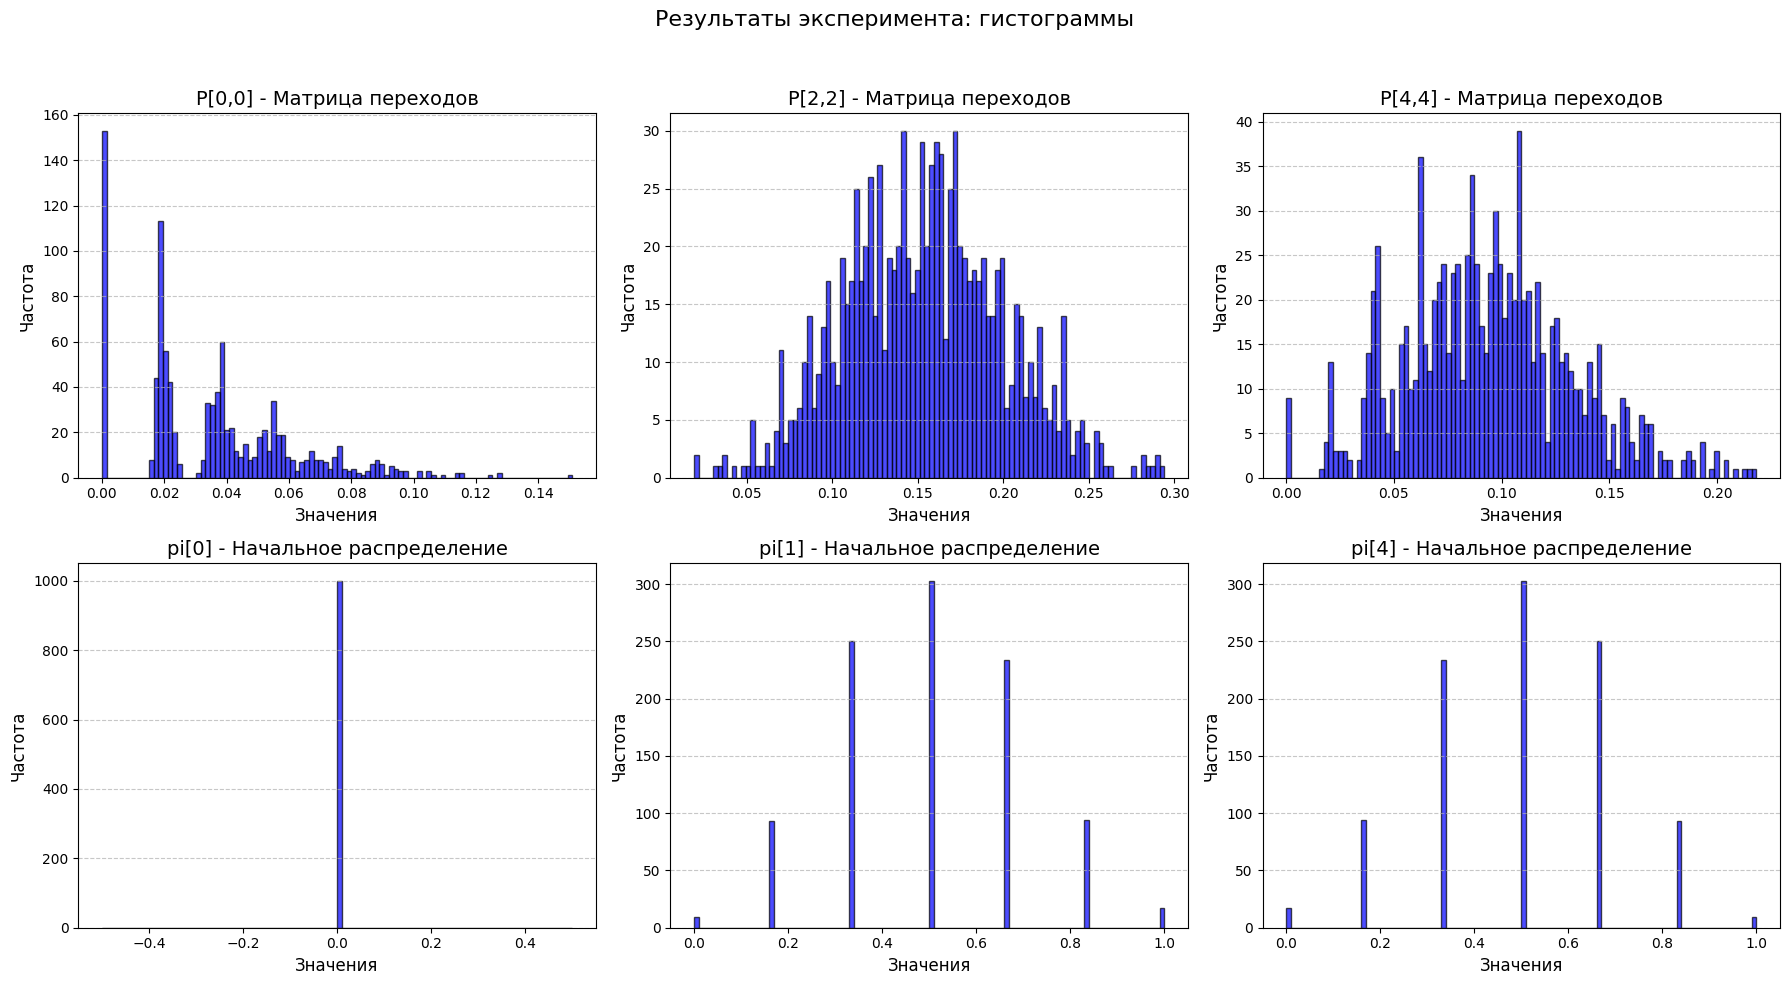

In [16]:
def plot_experiment_histograms(pi_results, P_results, bins=50):
    """
    Визуализирует гистограммы значений начального распределения и матрицы переходов Марковской цепи.

    Параметры:
        pi_results (np.ndarray): Результаты начального распределения (итерации x состояния).
        P_results (np.ndarray): Результаты матрицы переходов (итерации x состояния x состояния).
        bins (int): Количество бинов для гистограмм.
    """
    # Выбираем нужные элементы для визуализации
    p00 = P_results[:, 0, 0]  # Все P[0,0] из каждой итерации
    p22 = P_results[:, 2, 2]  # Все P[2,2]
    p44 = P_results[:, 4, 4]  # Все P[4,4]
    
    pi0 = pi_results[:, 0]  # Все pi[0]
    pi1 = pi_results[:, 1]  # Все pi[1]
    pi4 = pi_results[:, 4]  # Все pi[4]

    # Названия для графиков
    titles = [
        "P[0,0] - Матрица переходов",
        "P[2,2] - Матрица переходов",
        "P[4,4] - Матрица переходов",
        "pi[0] - Начальное распределение",
        "pi[1] - Начальное распределение",
        "pi[4] - Начальное распределение"
    ]
    
    data_list = [p00, p22, p44, pi0, pi1, pi4]
    
    # Настраиваем сетку графиков
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()  # Для удобной индексации

    for i, (data, title) in enumerate(zip(data_list, titles)):
        axes[i].hist(data, bins=bins, color="blue", edgecolor="black", alpha=0.7)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Значения", fontsize=12)
        axes[i].set_ylabel("Частота", fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.suptitle("Результаты эксперимента: гистограммы", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_experiment_histograms(np.array(pi_results), np.array(P_results),bins = 100)

## Делаем такую же движуху способом из 6.2


In [17]:
tetta_P = np.clip(2 * P - P_results, 0, 1)
tetta_pi = np.clip(2 * pi - pi_results, 0, 1)

In [18]:
pi_var = np.var(tetta_pi, axis=0)
P_var = np.var(tetta_P, axis=0)
df_pi = pd.DataFrame({'Дисперсия': pi_var})
df_P_var = pd.DataFrame(P_var, columns=[i + 1 for i in range(P_var.shape[1])], 
                        index=[i + 1 for i in range(P_var.shape[0])])
print("\nДисперсия для pi")
display(df_pi)
print("\nДисперсия для P:")
display(df_P_var)


Дисперсия для pi


,Дисперсия
0,0.000000
1,0.040719
2,0.000000
3,0.000000
4,0.040719



Дисперсия для P:


,1,2,3,4,5
1,0.000544,0.004400,0.002215,0.000560,0.002218
2,0.000508,0.001454,0.002765,0.003483,0.001510
3,0.002617,0.001718,0.002147,0.002157,0.003558
4,0.000121,0.001372,0.003534,0.003417,0.001282
5,0.004346,0.002835,0.000000,0.001176,0.001439


In [19]:
print("Квантили для n+1")
pt1_result = np.array([get_future_step(record, P_new, 1) for record, P_new in zip(last_records, tetta_P)])
pt1_lower = np.quantile(pt1_result, 0.05, axis=0)
pt1_upper = np.quantile(pt1_result, 0.95, axis=0)

print(pt1_lower)
print(pt1_upper)

Квантили для n+1
[0.         0.06438949 0.         0.01856591 0.04744586]
[0.67658103 0.68769231 0.43418506 0.47802639 0.39646809]


In [20]:
print("Квантили для n+2")
pt2_result = np.array([get_future_step(record, P_new, 2) for record, P_new in zip(last_records, tetta_P)])
pt2_lower = np.quantile(pt2_result, 0.05, axis=0)
pt2_upper = np.quantile(pt2_result, 0.95, axis=0)

print(pt2_lower)
print(pt2_upper)

Квантили для n+2
[0.07943226 0.11317568 0.12423664 0.12142637 0.10227514]
[0.30487715 0.49692791 0.28934969 0.35034985 0.22724482]


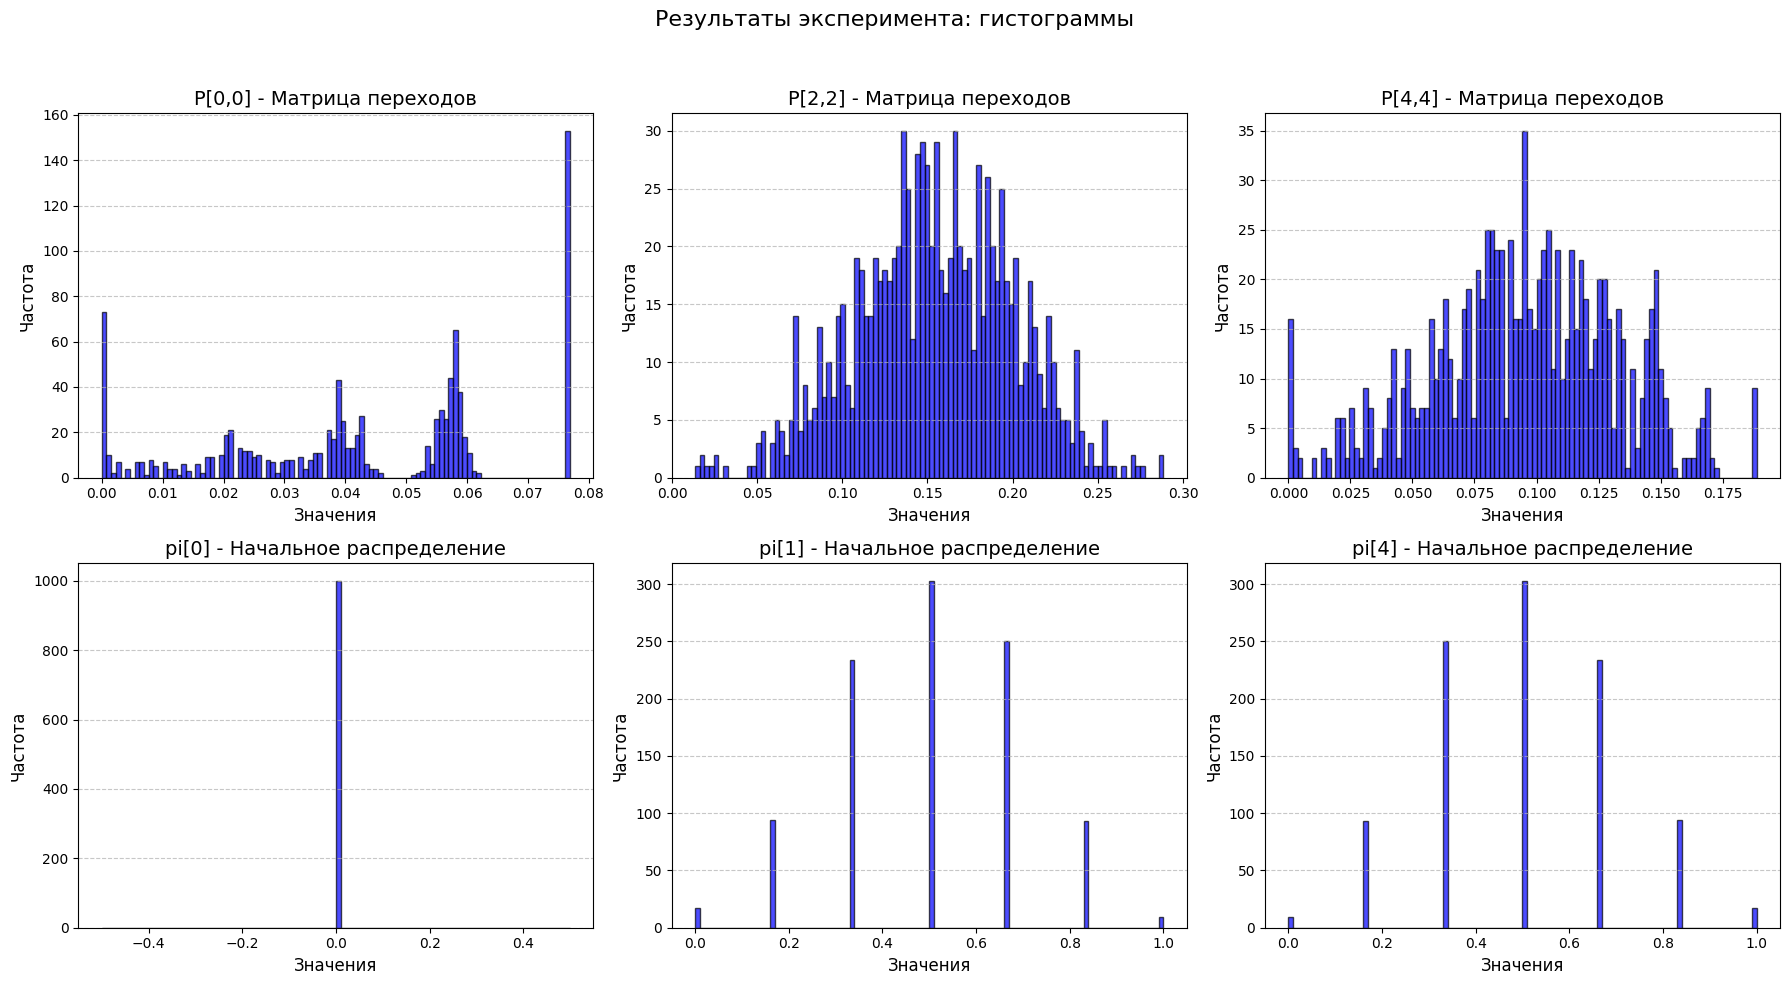

In [21]:
plot_experiment_histograms(np.array(tetta_pi), np.array(tetta_P),bins = 100)